### In the notetbook, we attempt to train the model with xgboost and use SHAP to check the feature importance.

# 1. Import data and packages

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, confusion_matrix, auc, accuracy_score

In [2]:
df = pd.read_csv('../database/2016-2022_median_imputation.csv')

In [3]:
df.head(3)

,year,ID,ticker,company_name,market_cap,bic_level_2,bic_level_3,unequal_voting,ceo_tenure,ipo_date,...,dividend_payout_ratio_industry_peers_percentile,dividend_payout_ratio_industry_peers_normalized,asset_to_equity_industry_peers_percentile,asset_to_equity_industry_peers_normalized,cash_conversion_cycle_industry_peers_percentile,cash_conversion_cycle_industry_peers_normalized,ev_ebitda_industry_peers_percentile,ev_ebitda_industry_peers_normalized,ev_ebit_industry_peers_percentile,ev_ebit_industry_peers_normalized
0,2016,1518855D US Equity,1518855D,Yahoo! Inc - Set up for Fundam,3.690000e+10,Media,Internet Media & Services,0.0,9.00000,NaN,...,50.000000,-0.242790,48.484848,-0.083976,50.000000,0.000000,15.151515,-0.475186,33.333333,0.110101
1,2016,1539941D UN Equity,1539941D,Spectra Energy LLC,2.880000e+10,Oil & Gas,Oil & Gas Producers,0.0,4.25000,NaN,...,100.000000,6.709610,80.263158,0.012658,51.162791,0.205408,74.358974,0.016097,89.743590,0.090888
2,2016,1556442D UA Equity,1556442D,GigPeak Inc,1.710000e+08,Tech Hardware & Semiconductors,Semiconductors,0.0,9.66667,NaN,...,37.313433,-0.372197,33.582090,-0.421308,84.375000,0.909061,67.164179,-0.099901,89.552239,0.272724


plot the distribution of "missing values" in the ascending order.

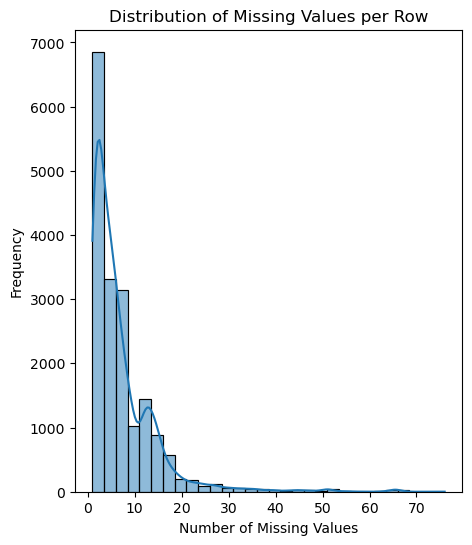

In [4]:
# Sort the 'missing_values' column in ascending order
sorted_missing_values = df['missing_values'].sort_values()

# Plot the distribution
plt.figure(figsize=(5, 6))
sns.histplot(sorted_missing_values, bins=30, kde=True)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values')
plt.ylabel('Frequency')
plt.show()

# 2. Retrieve necessary columns

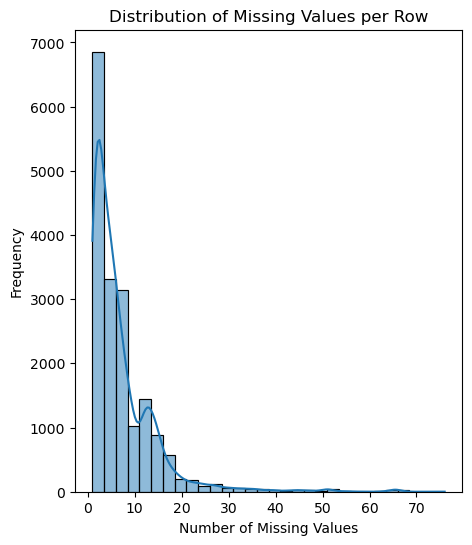

In [5]:
# Sort the 'missing_values' column in ascending order
sorted_missing_values = df['missing_values'].sort_values()

# Plot the distribution
plt.figure(figsize=(5, 6))
sns.histplot(sorted_missing_values, bins=30, kde=True)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values')
plt.ylabel('Frequency')
plt.show()


In [6]:
df = df[df['missing_values'] <= 20]

We obtain the list of column names that will be used for model training. 

In [7]:
binary_variables = ["unequal_voting", "classified_board_system","poison_pill"]

non_ratio_variables = [
    'capex', 'capex_percentile', 'capex_10bins_percentile', 'capex_10bins_normalized', 'capex_div_market_cap', 'capex_div_log_market_cap', 
    'net_capex', 'net_capex_percentile', 'net_capex_10bins_percentile', 'net_capex_10bins_normalized', 'net_capex_div_market_cap', 'net_capex_div_log_market_cap', 
    'short_term_wc', 'short_term_wc_percentile', 'short_term_wc_10bins_percentile', 'short_term_wc_10bins_normalized', 'short_term_wc_div_market_cap', 'short_term_wc_div_log_market_cap', 
    'long_term_wc', 'long_term_wc_percentile', 'long_term_wc_10bins_percentile', 'long_term_wc_10bins_normalized', 'long_term_wc_div_market_cap', 'long_term_wc_div_log_market_cap', 
    'ebitda', 'ebitda_percentile', 'ebitda_10bins_percentile', 'ebitda_10bins_normalized', 'ebitda_div_market_cap', 'ebitda_div_log_market_cap', 
    'ebit', 'ebit_percentile', 'ebit_10bins_percentile', 'ebit_10bins_normalized', 'ebit_div_market_cap', 'ebit_div_log_market_cap', 
    'net_income', 'net_income_percentile', 'net_income_10bins_percentile', 'net_income_10bins_normalized', 'net_income_div_market_cap', 'net_income_div_log_market_cap', 
    'net_debt', 'net_debt_percentile', 'net_debt_10bins_percentile', 'net_debt_10bins_normalized', 'net_debt_div_market_cap', 'net_debt_div_log_market_cap', 
    'ev', 'ev_percentile', 'ev_10bins_percentile', 'ev_10bins_normalized', 'ev_div_market_cap', 'ev_div_log_market_cap', 
    'repurchase', 'repurchase_percentile', 'repurchase_10bins_percentile', 'repurchase_10bins_normalized', 'repurchase_div_market_cap', 'repurchase_div_log_market_cap', 
    'net_repurchase', 'net_repurchase_percentile', 'net_repurchase_10bins_percentile', 'net_repurchase_10bins_normalized', 'net_repurchase_div_market_cap', 'net_repurchase_div_log_market_cap', 
    'total_compensation_to_executives', 'total_compensation_to_executives_percentile', 'total_compensation_to_executives_10bins_percentile', 'total_compensation_to_executives_10bins_normalized', 'total_compensation_to_executives_div_market_cap', 'total_compensation_to_executives_div_log_market_cap', 
    'total_compensation_to_board_members', 'total_compensation_to_board_members_percentile', 'total_compensation_to_board_members_10bins_percentile', 'total_compensation_to_board_members_10bins_normalized', 'total_compensation_to_board_members_div_market_cap', 'total_compensation_to_board_members_div_log_market_cap'
]

ratio_variables = [
    'ebitda_margin', 'ebitda_margin_industry_peers_percentile', 'ebitda_margin_industry_peers_normalized', 
    'operating_margin', 'operating_margin_industry_peers_percentile', 'operating_margin_industry_peers_normalized', 
    'sales_to_total_assets', 'sales_to_total_assets_industry_peers_percentile', 'sales_to_total_assets_industry_peers_normalized', 
    'normalized_roe', 'normalized_roe_industry_peers_percentile', 'normalized_roe_industry_peers_normalized', 
    'operating_roe', 'operating_roe_industry_peers_percentile', 'operating_roe_industry_peers_normalized', 
    'operating_roic', 'operating_roic_industry_peers_percentile', 'operating_roic_industry_peers_normalized', 
    'eps_adjusted_diluted', 'eps_adjusted_diluted_industry_peers_percentile', 'eps_adjusted_diluted_industry_peers_normalized', 
    'ev_to_sales', 'ev_to_sales_industry_peers_percentile', 'ev_to_sales_industry_peers_normalized', 
    'tobin_q_ratio', 'tobin_q_ratio_industry_peers_percentile', 'tobin_q_ratio_industry_peers_normalized', 
    'pb_ratio', 'pb_ratio_industry_peers_percentile', 'pb_ratio_industry_peers_normalized', 
    'pe_ratio', 'pe_ratio_industry_peers_percentile', 'pe_ratio_industry_peers_normalized', 
    'fcf_to_equity', 'fcf_to_equity_industry_peers_percentile', 'fcf_to_equity_industry_peers_normalized', 
    'sales_growth_rate', 'sales_growth_rate_industry_peers_percentile', 'sales_growth_rate_industry_peers_normalized', 
    'dividend_per_share', 'dividend_per_share_industry_peers_percentile', 'dividend_per_share_industry_peers_normalized', 
    'dividend_payout_ratio', 'dividend_payout_ratio_industry_peers_percentile', 'dividend_payout_ratio_industry_peers_normalized', 
    'asset_to_equity', 'asset_to_equity_industry_peers_percentile', 'asset_to_equity_industry_peers_normalized', 
    'cash_conversion_cycle', 'cash_conversion_cycle_industry_peers_percentile', 'cash_conversion_cycle_industry_peers_normalized', 
    'ev_ebitda', 'ev_ebitda_industry_peers_percentile', 'ev_ebitda_industry_peers_normalized', 
    'ev_ebit', 'ev_ebit_industry_peers_percentile', 'ev_ebit_industry_peers_normalized'
]

technical_variables = [
    "free_float_percentage",
    "rsi_14d",
    "rsi_30d",
    "volatility_30d",
    "volatility_90d",
    "volatility_180d",
    "volume_30d_average_to_outstanding",
    "insider_shares_percentage",
    "institution_ownership_percentage",
    "ceo_tenure",
    "total_return_5y",
    "total_return_4y",
    "total_return_3y",
    "total_return_2y",
    "total_return_1y",
    "total_return_6m",
    "total_return_3m"
]


factors = binary_variables + non_ratio_variables + ratio_variables + technical_variables

# 3. Train the model

In [8]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
    
def plot_roc_curve(y_true, y_pred, label=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    if label:
        plt.legend()

# plot_roc_curve(y_train, y_pred_val, label='Validation Set')
# plt.show()

## 3.1. XGBoost

In [9]:
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[factors]
y_train = train_data['targeted']

X_test = test_data[factors]
y_test = test_data['targeted']

xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

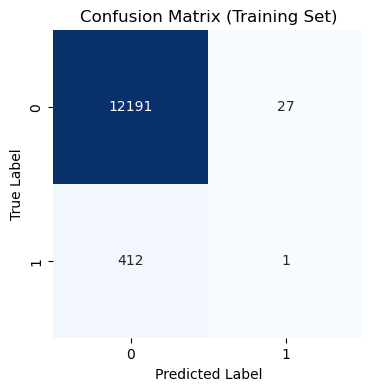

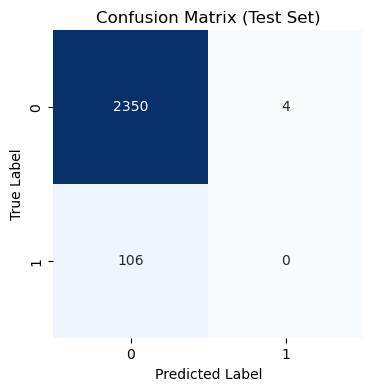

Training Accuracy: 0.97
Test Accuracy: 0.96


In [11]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.2)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.2)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train > 0.2)
test_accuracy = accuracy_score(y_test, y_pred_test > 0.2)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

## 3.2. Random Forest

In [12]:
# Splitting the data
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[factors]
y_train = train_data['targeted']

X_test = test_data[factors]
y_test = test_data['targeted']

# Training the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Cross-validation predictions for ROC curve
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
y_pred_train = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = clf.predict_proba(X_test)[:, 1]

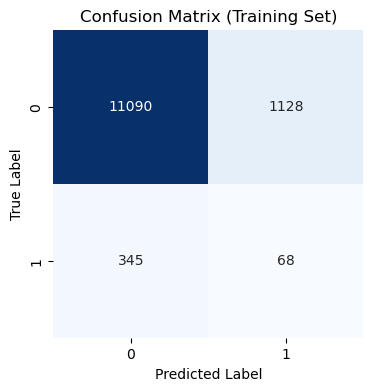

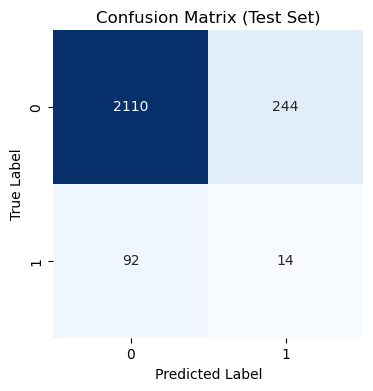

Training Accuracy: 0.88
Test Accuracy: 0.86


In [14]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.1)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train > 0.1)
test_accuracy = accuracy_score(y_test, y_pred_test > 0.1)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

In [15]:
bloomberg_factors = [
    "unequal_voting",
    "total_compensation_to_executives_10bins_percentile",
    "ebitda_margin_industry_peers_percentile",
    "sales_to_total_assets_industry_peers_percentile",
    "institution_ownership_percentage",
    "volume_30d_average_to_outstanding",
    "free_float_percentage",
    "total_return_5y",
    "total_return_3y",
    "total_return_2y",
    "total_return_1y",
    "total_return_6m",
    "pb_ratio_industry_peers_percentile",
    "ev_to_sales_industry_peers_percentile",
    "ev_ebitda_industry_peers_percentile",
    "pe_ratio_industry_peers_percentile" 
]

In [16]:
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[bloomberg_factors]
y_train = train_data['targeted']

X_test = test_data[bloomberg_factors]
y_test = test_data['targeted']

xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

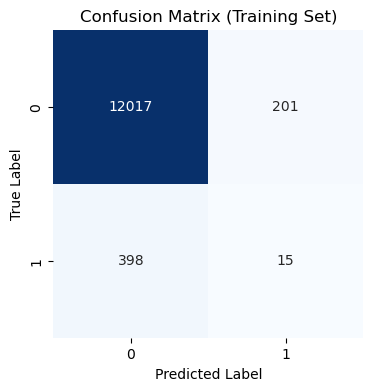

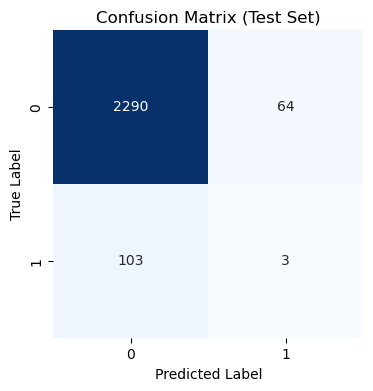

Training Accuracy: 0.95
Test Accuracy: 0.93


In [18]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.1)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train > 0.1)
test_accuracy = accuracy_score(y_test, y_pred_test > 0.1)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

In [19]:
# Splitting the data
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[bloomberg_factors]
y_train = train_data['targeted']

X_test = test_data[bloomberg_factors]
y_test = test_data['targeted']

# Training the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [20]:
y_pred_train = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = clf.predict_proba(X_test)[:, 1]

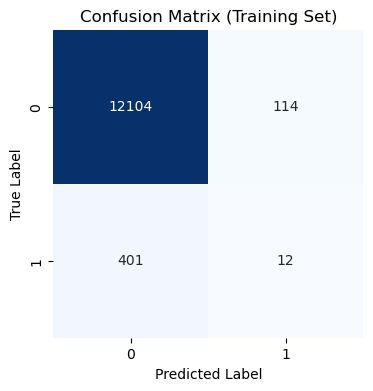

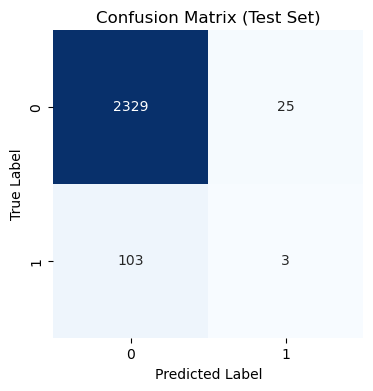

Training Accuracy: 0.96
Test Accuracy: 0.95


In [21]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.2)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.2)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train > 0.2)
test_accuracy = accuracy_score(y_test, y_pred_test > 0.2)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")